+----------+------+--------+-------------------+-------------------+----------+
|prediction|Months|Sunspots|           features|             center|  Distance|
+----------+------+--------+-------------------+-------------------+----------+
|         0|   4.0|    85.0|             [85.0]|[87.22663419414087]|    4.9579|
|         0|   5.0|    83.5|             [83.5]|[87.22663419414087]| 13.887802|
|         0|   6.0|    94.8|[94.80000305175781]|[87.22663419414087]| 57.355915|
|         0|   8.0|    75.9| [75.9000015258789]|[87.22663419414087]|  128.2926|
|         0|   9.0|    75.5|             [75.5]|[87.22663419414087]| 137.51395|
|         0|  11.0|    85.2|[85.19999694824219]|[87.22663419414087]| 4.1072583|
|         0|  12.0|    73.3|[73.30000305175781]|[87.22663419414087]| 193.95105|
|         0|  13.0|    75.9| [75.9000015258789]|[87.22663419414087]|  128.2926|
|         0|  14.0|    89.2|[89.19999694824219]|[87.22663419414087]| 3.8941605|
|         0|  15.0|    88.3|[88.30000305

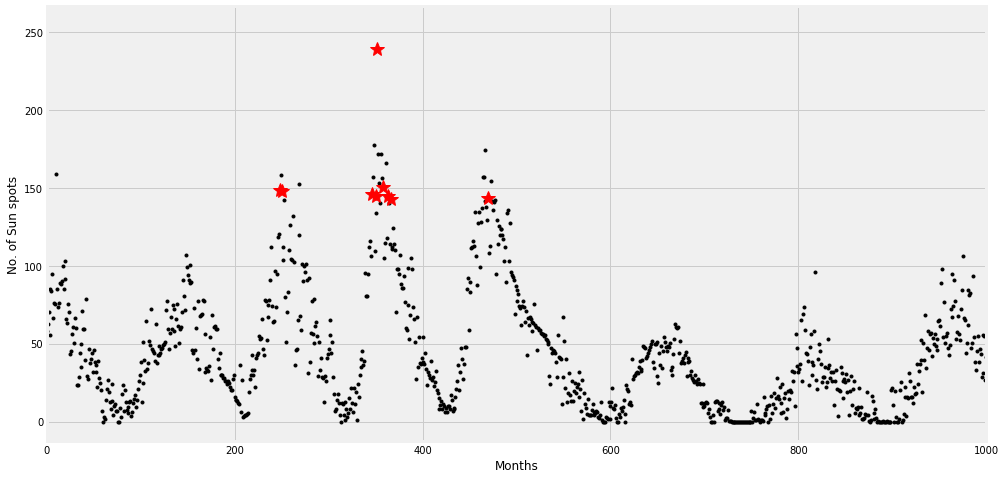

Anomalies
+------+--------+
|Months|Sunspots|
+------+--------+
| 248.0|   148.8|
| 250.0|   148.1|
| 352.0|   238.9|
| 358.0|   150.3|
|1055.0|   206.3|
|1462.0|   147.5|
|2379.0|   149.8|
|2380.0|   201.3|
|2494.0|   201.3|
|2495.0|   192.1|
|2501.0|   200.7|
|2504.0|   235.8|
|2505.0|   253.8|
|2506.0|   210.9|
|2507.0|   239.4|
|2508.0|   202.5|
|2511.0|   196.0|
|2515.0|   200.2|
|2516.0|   201.2|
|2520.0|   217.4|
|2526.0|   149.6|
|2527.0|   199.6|
|2765.0|   149.5|
|2782.0|   147.9|
|2795.0|   150.1|
|2885.0|   196.2|
|2898.0|   149.4|
|2899.0|   200.3|
|2916.0|   150.0|
|3032.0|   150.7|
| 346.0|   146.0|
| 351.0|   145.0|
| 363.0|   145.0|
| 366.0|   143.0|
| 470.0|   143.3|
|1047.0|   142.9|
|1068.0|   144.9|
|1461.0|   146.4|
|1466.0|   143.2|
|1468.0|   145.5|
|2262.0|   145.1|
|2396.0|   143.3|
|2403.0|   147.0|
|2408.0|   145.3|
|2410.0|   143.5|
|2521.0|   143.1|
|2528.0|   145.2|
|2532.0|   146.3|
|2790.0|   143.8|
|2901.0|   145.5|
+------+--------+
only showing top 5

In [160]:

from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import FloatType,IntegerType
from pyspark.ml.clustering import KMeans
import pyspark.sql.functions as F

from pyspark.sql import SparkSession

from matplotlib import style
style.use('fivethirtyeight')
%matplotlib inline

#First way to load data 
# sunspots = sc.textFile('./sunspots.txt')
# data = sunspots.map(lambda k: k.split("\t"))

# #Secound Way to  to load data 
spark = SparkSession \
        .builder \
        .appName("clustering") \
        .getOrCreate()
data = spark.read.text("./sunspots.txt")
data = data.rdd.map(lambda k: k['value'].split("\t"))


#Adding columns and casting 
sunspots_df = data.toDF(['Months','Sunspots'])
sunspots_df = sunspots_df.withColumn("Months", sunspots_df["Months"].cast(FloatType()))
sunspots_df = sunspots_df.withColumn("Sunspots", sunspots_df["Sunspots"].cast(FloatType()))



def kMeans(sunspots_df):
    #Vectrozing columns
    vecAssembler = VectorAssembler(inputCols=["Sunspots"], outputCol="features")
    new_df = vecAssembler.transform(sunspots_df)

    #fitting KMeans model
    kmeans = KMeans(k=6, seed=1)  
    model = kmeans.fit(new_df.select('features'))

    #transforming your initial dataframe to include cluster
    transformed = model.transform(new_df)

    centers = model.clusterCenters()
  
    d_clusters = {int(i):[float(centers[i][j]) for j in range(len(centers[i]))] 
                  for i in range(len(centers))}


    df_centers = spark.sparkContext.parallelize([(k,)+(v,) for k,v in d_clusters.items()]).toDF(['prediction','center'])


    df_pred = transformed.withColumn('prediction',F.col('prediction').cast(IntegerType()))
    df_pred = df_pred.join(df_centers,on='prediction',how='left')


    get_dist = F.udf(lambda features, center : 
                     float(features.squared_distance(center)),FloatType())

    df_pred = df_pred.withColumn('Distance',get_dist(F.col('features'),F.col('center')))
    
    df_pred.show()
    
    return df_pred.filter(df_pred.Distance>400)
    
def plotGraph(sunspots_df):
    anomalies = kMeans(sunspots_df)
    
    plt.figure(figsize=(15, 8))
     
    plt.plot(sunspots_df.select("Months").toPandas(), sunspots_df.select("Sunspots").toPandas(), "k.")
    plt.xlim(0, 1000)
    plt.xlabel("Months")
    plt.ylabel("No. of Sun spots")
    
    #plot anomalies 
    plt.plot(anomalies.select("Months").toPandas(), anomalies.select("Sunspots").toPandas(), "r*", markersize=15)

    plt.grid(True)
    plt.show()
    
    print("Anomalies")
    print(anomalies.select(['Months','Sunspots']).show(50))
    

plotGraph(sunspots_df)